In [1]:
%load_ext autoreload
%autoreload 2

%autosave 10

Autosaving every 10 seconds


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde, linregress, ttest_rel, wilcoxon

# sns.set_palette("Set2")
%matplotlib widget

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Palatino"],
    }
)

In [3]:
model_ids = ["svm", "svm_ar", "cnn1d", "cnn2d", "ar"]
model_valid_ids = [name + "_valid" for name in model_ids]

model_names = ["SVM", "AR-SVM", "1D-CNN", "2D-CNN","AR-1D-CNN"]

# Synthetic Data:

In [4]:
datasets = {
    "Beta/Gamma ERD/ERS": "../code/_assets/beta_gamma.csv",
    "Beta Waveform Sharpness": "../code/_assets/beta_sharpness.csv",
    "Non-linear Phase": "../code/_assets/phase.csv",
    "Phase-Amplitude Coupling": "../code/_assets/pac.csv",
    "Cross-channel PAC": "../code/_assets/cross_pac.csv",
    "Phase-shift": "../code/_assets/phase_shift.csv",
    "Burst Length": "../code/_assets/burst_length.csv",
}

In [5]:
def plot_results(csv_path: os.PathLike, name: str, save: bool = False):

    df = pd.read_csv(csv_path, index_col=0)
    df.snr = df.snr.apply(lambda x: round(x, 3))

    snr_means = df.groupby("snr").mean()
    snr_stds = df.groupby("snr").std()

    fig, ax = plt.subplots()

    for ix, model_name in enumerate(model_valid_ids):
        ax.plot(
            snr_means.index, snr_means[model_name], c=f"C{ix}", label=model_names[ix]
        )
        ax.fill_between(
            snr_means.index,
            snr_means[model_name] - snr_stds[model_name],
            snr_means[model_name] + snr_stds[model_name],
            color=f"C{ix}",
            alpha=0.1,
        )

    #ax.vlines(1.0, *ax.get_ylim(), color="k", linestyle="--", linewidth=0.5)
    ax.set_xlabel("SNR")
    ax.set_ylabel("Out-of-sample performance")
    ax.legend()

    ax.set_title(name)

    if save:
        fname = Path(csv_path).name
        save_path = Path("outputs").name / Path(fname).with_suffix(".png")
        fig.savefig(save_path)

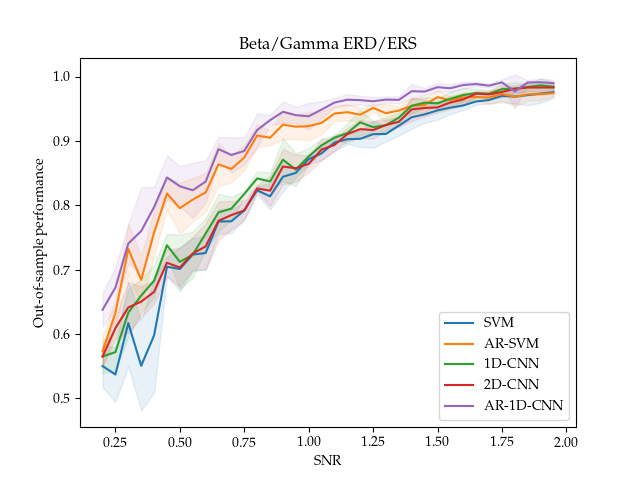

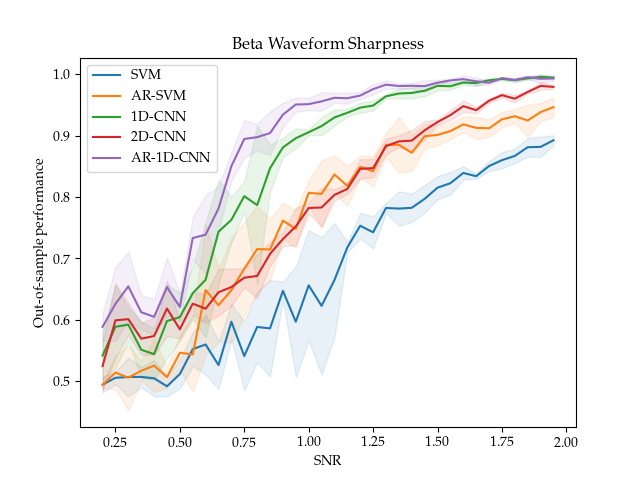

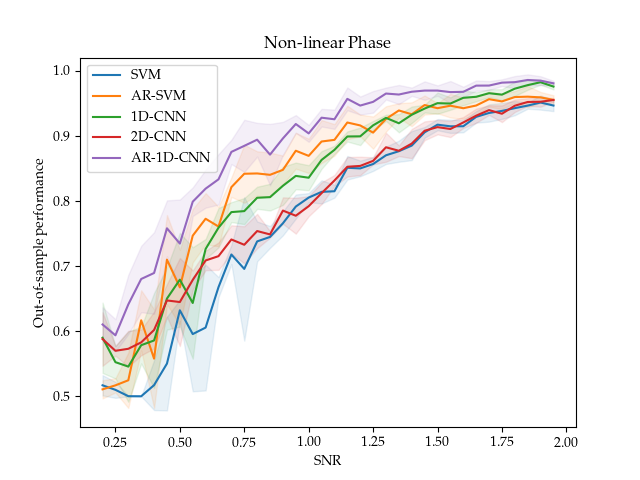

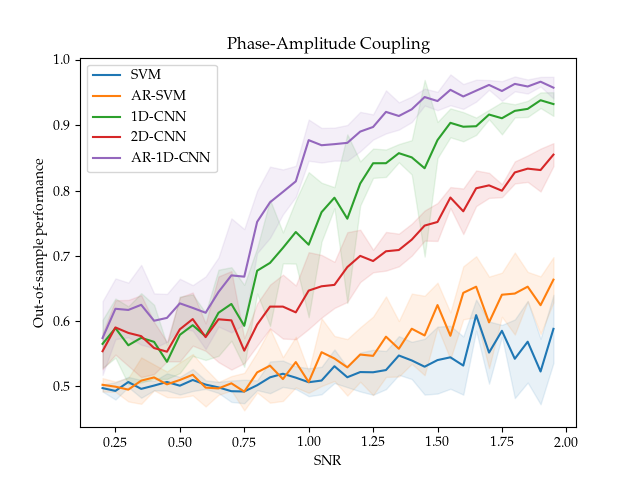

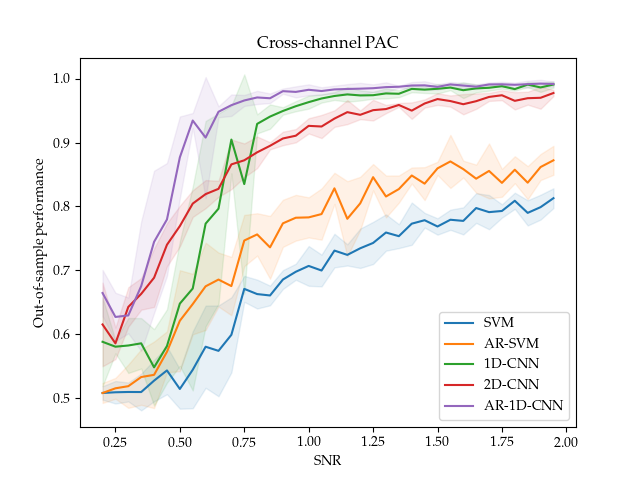

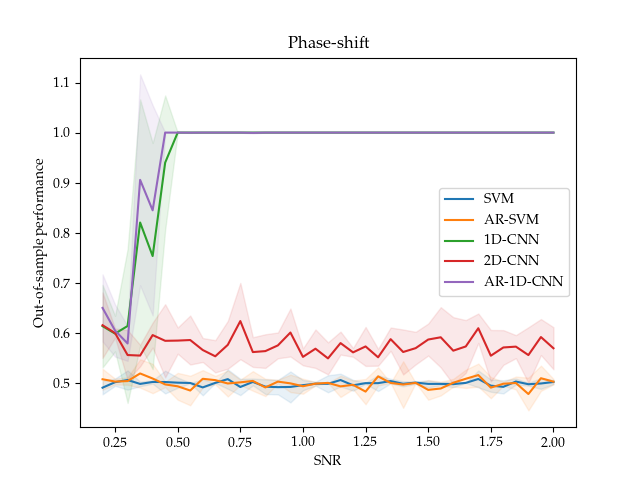

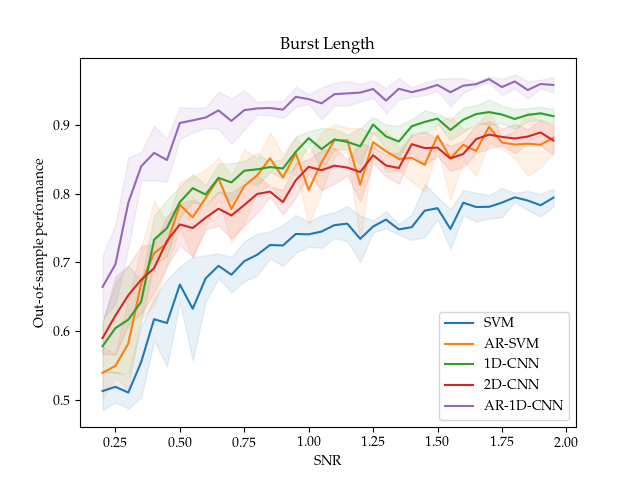

In [6]:
for name, path in datasets.items():
    plot_results(path, name, save=False)

In [7]:
def concat_tasks(csv_path, df_all):
    df = pd.read_csv(csv_path, index_col=0)
    df.snr = df.snr.apply(lambda x: round(x, 3))

    if df_all is not None:
        df_all = pd.concat([df_all, df], ignore_index=True)

    return df_all

In [8]:
df_all = pd.DataFrame()

for _, path in datasets.items():
    df_all = concat_tasks(path, df_all)

In [9]:
df_all[model_valid_ids].mean()

svm_valid       0.664037
svm_ar_valid    0.718025
cnn1d_valid     0.841478
cnn2d_valid     0.760656
ar_valid        0.890523
dtype: float64

[Text(0, 0, 'SVM'),
 Text(1, 0, 'AR-SVM'),
 Text(2, 0, '1D-CNN'),
 Text(3, 0, '2D-CNN'),
 Text(4, 0, 'AR-1D-CNN')]

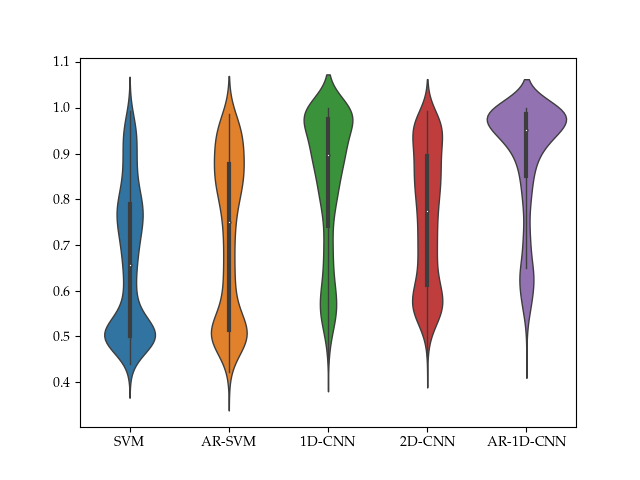

In [10]:
fig, ax = plt.subplots()

sns.violinplot(df_all[model_valid_ids], linewidth=1.0, inner="box")
ax.set_xticklabels(model_names)

In [11]:
def pairwise_ttest(df, ref_name):

    models = ["svm_ar", "cnn1d", "cnn2d", "ar"]
    stats = dict()
    for name in models:
        test_ = ttest_rel(df[name + "_valid"], df[ref_name])
        stats[name + "_valid"] = [test_.statistic, test_.pvalue]

    return stats

In [12]:
pairwise_ttest(df_all, "svm_valid")

{'svm_ar_valid': [34.54694078998283, 3.35591960284334e-188],
 'cnn1d_valid': [41.41587288545643, 4.163077632721369e-243],
 'cnn2d_valid': [44.71852765704153, 3.1632054375530134e-269],
 'ar_valid': [56.64004113800057, 0.0]}

In [13]:
def summarize(csv_path, name):

    df = pd.read_csv(csv_path, index_col=0)
    df.snr = df.snr.apply(lambda x: round(x, 3))

    snr_means = df.groupby("snr").mean()
    snr_stds = df.groupby("snr").std()

    print(name)
    print(f"{snr_means.loc[1][model_valid_ids]}")
    print("")

In [14]:
for name, path in datasets.items():
    df_all = summarize(path, name)

Beta/Gamma ERD/ERS
svm_valid       0.872086
svm_ar_valid    0.923451
cnn1d_valid     0.876246
cnn2d_valid     0.864844
ar_valid        0.938894
Name: 1.0, dtype: float64

Beta Waveform Sharpness
svm_valid       0.656208
svm_ar_valid    0.807016
cnn1d_valid     0.905838
cnn2d_valid     0.782277
ar_valid        0.951627
Name: 1.0, dtype: float64

Non-linear Phase
svm_valid       0.805815
svm_ar_valid    0.870026
cnn1d_valid     0.836391
cnn2d_valid     0.792570
ar_valid        0.904610
Name: 1.0, dtype: float64

Phase-Amplitude Coupling
svm_valid       0.506049
svm_ar_valid    0.506336
cnn1d_valid     0.716961
cnn2d_valid     0.646581
ar_valid        0.877313
Name: 1.0, dtype: float64

Cross-channel PAC
svm_valid       0.706730
svm_ar_valid    0.782831
cnn1d_valid     0.963486
cnn2d_valid     0.926318
ar_valid        0.982868
Name: 1.0, dtype: float64

Phase-shift
svm_valid       0.495440
svm_ar_valid    0.493288
cnn1d_valid     1.000000
cnn2d_valid     0.551961
ar_valid        1.000000


# Patient Data:

In [15]:
df = pd.read_csv("../code/_assets/patients.csv", index_col=0)
df = df.set_index(["pat", "task", "stim", "fold"])

df

svm_train  svm_valid  cnn1d_train  cnn1d_valid  \
pat task     stim fold                                                   
ET1 Pegboard ON   3      0.650583   0.496533     0.747277     0.715057   
                  1      0.887196   0.620370     0.714046     0.709026   
                  0      0.849045   0.498480     0.681681     0.784081   
                  2      0.913817   0.605078     0.608188     0.435123   
             OFF  0      0.898728   0.604348     0.846559     0.675549   
...                           ...        ...          ...          ...   
ET8 Posture  OFF  0      0.962092   0.770001     0.888727     0.760786   
                  1      0.955804   0.860066     0.940114     0.927866   
                  2      0.961817   0.792113     0.889793     0.886540   
                  3      0.956550   0.779866     0.812263     0.881333   
                  4      0.979230   0.617345     0.994041     0.717176   

                        cnn2d_train  cnn2d_valid  ar_train  ar_valid  \
pat task     stim fold                                                 
ET1 Pegboard ON   3        0.906433     0.673241  0.968526  0.838647   
                  1        0.996767     0.716600  0.985404  0.777131   
                  0        0.856248     0.564370  0.715007  0.532375   
                  2        0.753465     0.795139  0.942794  0.288793   
             OFF  0        0.974510     0.622406  0.797557  0.657674   
...                             ...          ...       ...       ...   
ET8 Posture  OFF  0        0.933599     0.820542  0.983577  0.878099   
                  1        0.987702     0.866892  0.898747  0.934039   
                  2        0.886389     0.881181  0.976249  0.987584   
                  3        0.964663     0.858864  0.994153  0.923441   
                  4        0.987584     0.671003  0.991759  0.726433   

                        svm_ar_train  svm_ar_valid  
pat task     stim fold                              
ET1 Pegboard ON   3         0.648595      0.461538  
                  1         1.000000      0.524568  
                  0         0.952194      0.495392  
                  2         0.999018      0.560973  
             OFF  0         0.943389      0.570241  
...                              ...           ...  
ET8 Posture  OFF  0         1.000000      0.750635  
                  1         1.000000      0.891716  
                  2         1.000000      0.839683  
                  3         1.000000      0.817545  
                  4         1.000000      0.558846  

[200 rows x 10 columns]

## Per-fold statistics:

In [16]:
df[model_valid_ids].mean()

svm_valid       0.747820
svm_ar_valid    0.790160
cnn1d_valid     0.809228
cnn2d_valid     0.792106
ar_valid        0.869529
dtype: float64

[Text(0, 0, 'SVM'),
 Text(1, 0, 'AR-SVM'),
 Text(2, 0, '1D-CNN'),
 Text(3, 0, '2D-CNN'),
 Text(4, 0, 'AR-1D-CNN')]

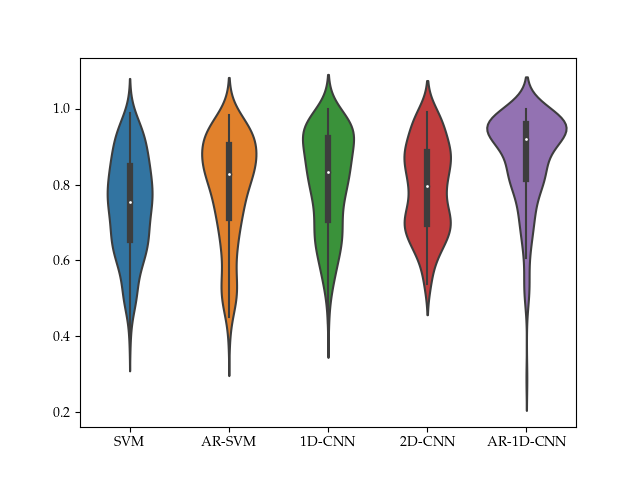

In [17]:
fig, ax = plt.subplots()

sns.violinplot(df[model_valid_ids])
ax.set_xticklabels(model_names)

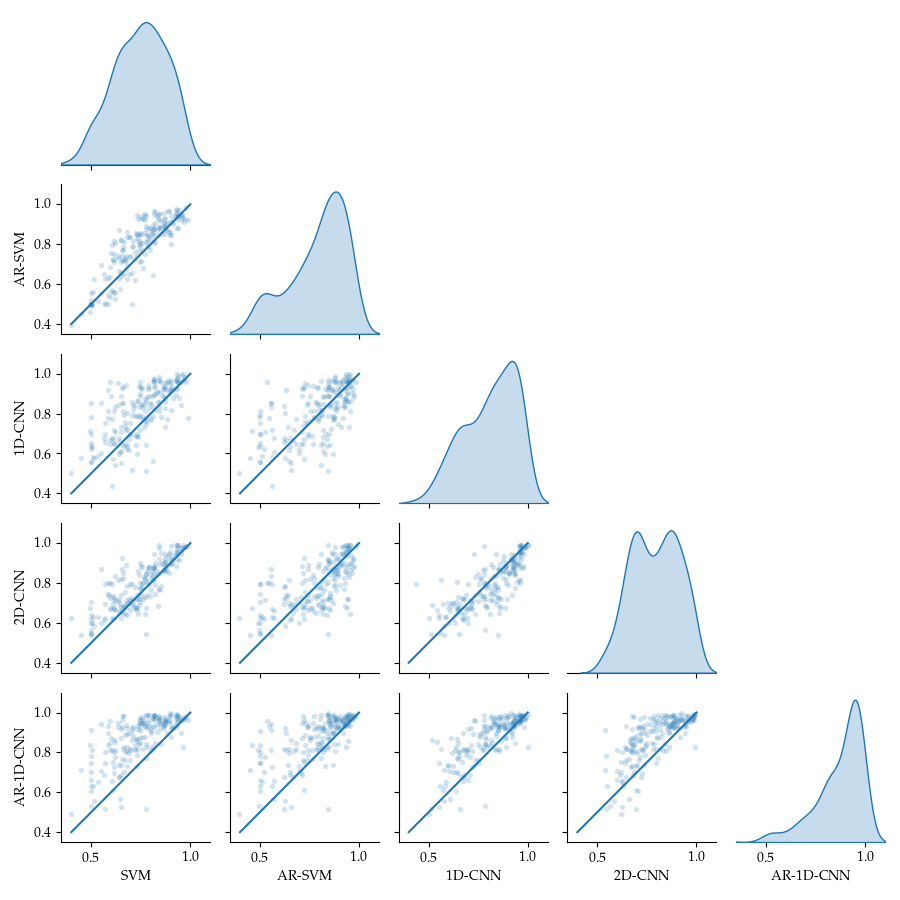

In [18]:
df_pair = df[model_valid_ids]
df_pair.columns = model_names

g = sns.pairplot(df_pair, diag_kind="kde", corner=True, plot_kws = {'alpha':0.2, 's':15})

for ax in g.figure.axes:
    
    spec = ax.get_subplotspec()
    
    if spec.rowspan[0] == spec.colspan[0]:
        ax.set_xlim(0.35,1.1)
    else: 
        ax.set_xlim(0.35,1.1)
        ax.set_ylim(0.35,1.1)
        ax.plot([0.4,1],[0.4,1])    

g.figure.set_size_inches(9, 9)
g.figure.tight_layout()


In [21]:
pairwise_ttest(df, "svm_valid")

{'svm_ar_valid': [8.125638039914474, 4.6360285579840454e-14],
 'cnn1d_valid': [8.33415871114476, 1.2653487397220042e-14],
 'cnn2d_valid': [8.241975117841744, 2.2507920107388937e-14],
 'ar_valid': [16.660698317908114, 1.3467185536840428e-39]}

In [22]:
pairwise_ttest(df, "cnn1d_valid")

{'svm_ar_valid': [-2.2384117488353206, 0.02630197707087343],
 'cnn1d_valid': [nan, nan],
 'cnn2d_valid': [-2.891421818527797, 0.004261255277036567],
 'ar_valid': [10.455719424252543, 1.1302900061507379e-20]}

In [23]:
def get_scatter(df, name1, name2, label_x, label_y):

    fig, ax = plt.subplots()

    x1, x2 = df[name1].values, df[name2].values

    test = linregress(x1, x2)
    t_test = ttest_rel(x1, x2)

    def reg(x):
        return test.slope * x + test.intercept

    ax.scatter(x1, x2, alpha=0.6)

    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)

    ax.plot([0.4, 1], [0.4, 1.0], c="k", linestyle="--", linewidth=0.5)
    # ax.plot([0.4,1],[reg(0.4),reg(1.0)],label=f"{test.slope:.2f} $\cdot x$ + {test.intercept:.2f} (t-test p = {t_test.pvalue:.2e})",c='C1')
    # ax.legend()

    print(t_test)

In [24]:
def get_kde(df, name1, name2):

    fig, ax = plt.subplots(figsize=(2, 2))

    x1, x2 = df[name1].values, df[name2].values
    delta_mean = np.mean(x2 - x1)

    sns.kdeplot(x2 - x1, fill=True)

    kde = gaussian_kde(x2 - x1)
    x = np.linspace(-0.15, 0.15, 200)
    x_max = x[kde(x).argmax()]

    ax.text(delta_mean + 0.02, kde(x).max() + 0.01, f"mean = {delta_mean:.3f}")
    print(x_max)

    ax.vlines(delta_mean, *ax.get_ylim(), color="k", linestyle="--", linewidth=0.5)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.set_yticks([])
    ax.set_ylabel("")

0.05050251256281407


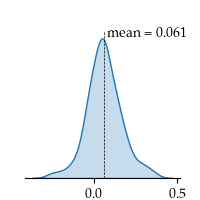

In [25]:
get_kde(df, "svm_valid", "cnn1d_valid")

0.036934673366834175


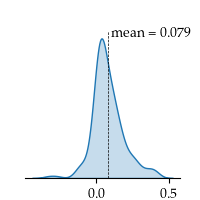

In [26]:
get_kde(df, "svm_ar_valid", "ar_valid")

## Cross-fold statistics:

In [27]:
grouped = df.groupby(["pat", "task", "stim"])
grouped_mean = grouped.mean()
grouped_std = grouped.std()

In [28]:
grouped_mean[model_valid_ids].mean()

svm_valid       0.747820
svm_ar_valid    0.790160
cnn1d_valid     0.809228
cnn2d_valid     0.792106
ar_valid        0.869529
dtype: float64

In [29]:
grouped_std[model_valid_ids].mean()

svm_valid       0.064129
svm_ar_valid    0.080680
cnn1d_valid     0.062310
cnn2d_valid     0.054955
ar_valid        0.065704
dtype: float64

TtestResult(statistic=7.15802891989922, pvalue=1.3017034177896178e-08, df=39)


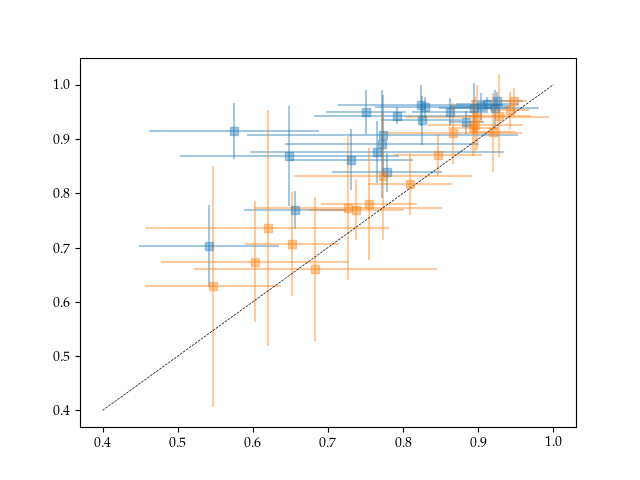

In [33]:
fig, ax = plt.subplots()

model1, model2 = "svm_ar_valid", "ar_valid"

x1, x2 = grouped_mean[model1].values, grouped_mean[model2].values
x1_std, x2_std = grouped_std[model1].values, grouped_std[model2].values

sig =[]
non_sig = []

for jj in range(len(x1)):
    if x2[jj] - x2_std[jj] > x1[jj]:
        sig.append(jj)
    else:
        non_sig.append(jj)

ax.errorbar(x1[sig], x2[sig], xerr=x1_std[sig], yerr=x2_std[sig], fmt="s", alpha=0.4)
ax.errorbar(x1[non_sig], x2[non_sig], xerr=x1_std[non_sig], yerr=x2_std[non_sig], fmt="s", alpha=0.4)


ax.plot([0.4, 1], [0.4, 1.0], c='k', linestyle='--', linewidth=0.5)

print(ttest_rel(x2, x1))

In [31]:
pairwise_ttest(grouped_mean, "svm_valid")

{'svm_ar_valid': [4.967162726565359, 1.3890890965821324e-05],
 'cnn1d_valid': [5.466653461793054, 2.847534528305691e-06],
 'cnn2d_valid': [5.4206140330354975, 3.297607577310012e-06],
 'ar_valid': [11.176258739425478, 1.0009137350386918e-13]}